In [1]:
## Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import io
import cv2
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Add, MaxPooling2D, \
                                    Conv2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report
from scikitplot.metrics import plot_roc

# path = 'C:/Users/user/Jupyter/image-processing/COVID-19_Radiography_Database'
path = '/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database'

# for dirname, _, filenames in os.walk(path):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7848555418371383802
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13775165985745023678
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15687541056
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17871449424623679054
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4395692066869228098
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
print(tf.__version__)
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
labels = ["COVID-19", "NORMAL", "Viral Pneumonia"]

2.3.1


### Visualize Images In Different Classes

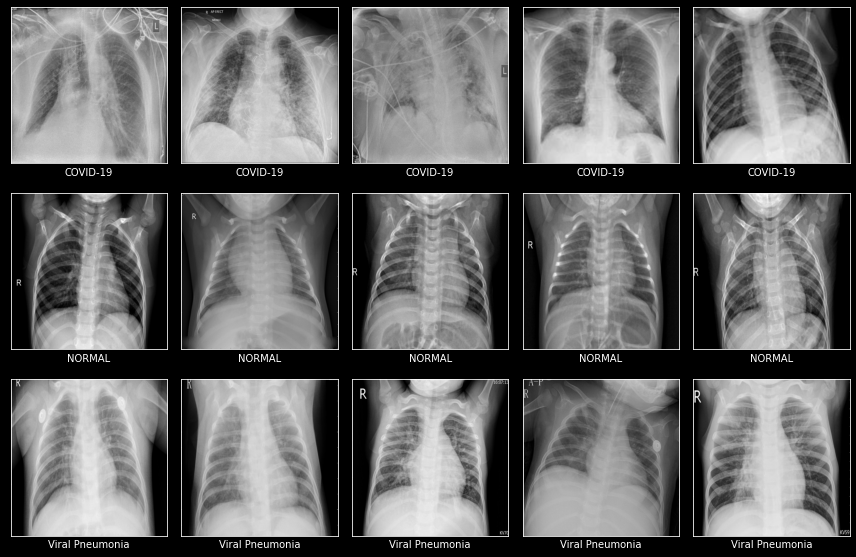

In [3]:
plt.style.use("dark_background")
# Randomly select 5 images in each category
fig, axs = plt.subplots(len(labels), 5, figsize = (12, 8))

class_len = {}
for i, c in enumerate(labels):
    class_path = os.path.join(path, c)
    all_images = os.listdir(class_path)
    sample_images = random.sample(all_images, 5)
    class_len[c] = len(all_images)
    
    for j, image in enumerate(sample_images):
        img_path = os.path.join(class_path, image)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = c, xticks = [], yticks = [])
        

fig.tight_layout()

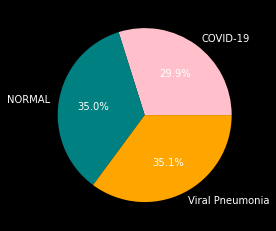

In [4]:
# Check the percentage contribution of each category.
fig, ax = plt.subplots()
ax.pie(
    class_len.values(),
    labels = class_len.keys(),
    autopct = "%1.1f%%",
    colors = ["pink", "teal", "orange"]
)
fig.show()

In [5]:
# Hyperparameters Settings
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

### Data Preprocessing & Data Augmentation

In [6]:
# Data Generator
datagen_train = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range = 15, 
#     horizontal_flip = True,
    shear_range = 0.05,
    width_shift_range = 0.15,
    height_shift_range = 0.15, 
    zoom_range = 0.1
)

datagen_val = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2 
)    

train_generator = datagen_train.flow_from_directory(
    directory = path,
    classes = labels,
    seed = SEED,
    batch_size = BATCH_SIZE, 
    shuffle = True,
    interpolation="bilinear",
    follow_links=False,
    subset = 'training'
)

valid_generator = datagen_val.flow_from_directory(
    directory = path,
    classes = labels,
    seed = SEED,
    batch_size = BATCH_SIZE, 
    shuffle = True,
    interpolation="bilinear",
    follow_links=False,
    subset = 'validation'
)

Found 3064 images belonging to 3 classes.
Found 765 images belonging to 3 classes.


In [7]:
# Check labeling
valid_generator.class_indices

{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}

### Display Augmented Images

In [8]:
# Get Second Batch of Augmented Images
next(train_generator)  # returns the next batch of images and labels 
batch = next(train_generator)  
print(batch[0].shape) # batch[0] is the images, batch[1] are the labels

(32, 256, 256, 3)


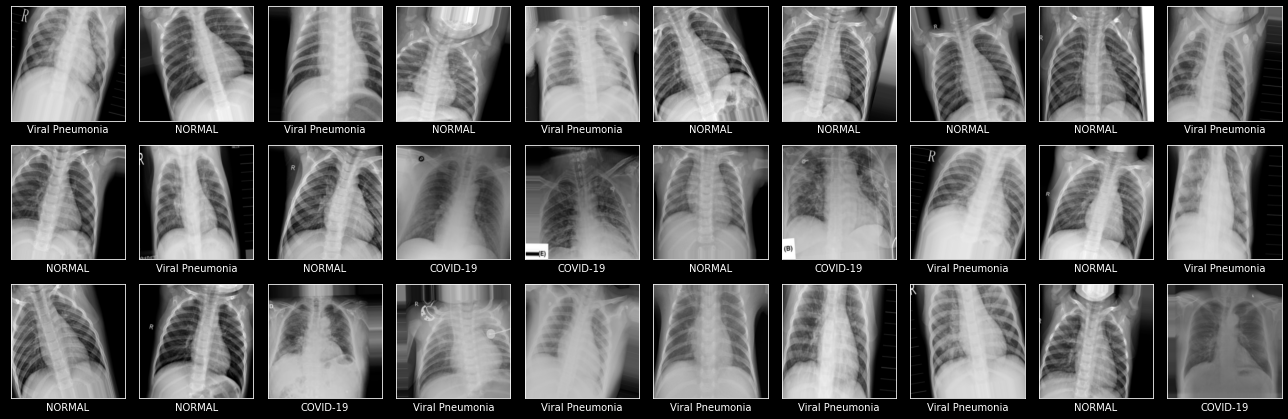

In [9]:
# Show processed image and their corresponding label
display_len = 30
fig, axs = plt.subplots(3, 10, figsize = (18, 6))

j = 0
for n in range(display_len):
    i = n%3
    if j == 10: j=0
    axs[i, j].imshow(batch[0][n])
    label = labels[np.argmax(batch[1][n])] # get string label from one-hot vector
#     axs[i, j].set(xlabel = label)
    axs[i, j].set(xlabel = label, xticks = [], yticks = [])
    j += 1

fig.tight_layout()

### Load Pretrained InceptionV3

In [10]:
base_model = InceptionV3(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = Input((256, 256, 3)),
)

87916544/87910968 [==============================] - 1s 0us/step


In [11]:
base_model.trainable = True
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Create Transfer Learning Model

In [12]:
# Add classification head to the model
head_model_start = base_model.output
head_model = GlobalAveragePooling2D()(head_model_start)
head_model = Flatten()(head_model) 
head_model = Dense(256, activation = "relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(128, activation = "relu")(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(3, activation = "softmax")(head_model) # 3 output classes

cnn_model = Model(inputs = base_model.input, outputs = head_model)
cnn_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

mixed1 (Concatenate)            (None, 29, 29, 288)  0           activation_12[0][0]              
                                                                 activation_14[0][0]              
                                                                 activation_17[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 29, 29, 64)   18432       mixed1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 29, 29, 64)   192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
activation_22 (Activation)      (None, 29, 29, 64)   0           batch_normalization_22[0][0]     
__________

In [13]:
# Compile the model

# In this task, the False Negatives(recall) in the Covid-19 detection is way more important 
# than False Positives(precision).
# Allowed to declare normal people as being COVID-19 positive. >> False Negative Cases
# NOT allowed to declare COVID-19 positive people as being normal. >> False Positive Cases

metrics_list = ["accuracy"]
metrics_list += [Recall(class_id = i) for i in range(len(labels))] 
metrics_list += [Precision(class_id = i) for i in range(len(labels))]

op = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE, epsilon=1e-07)

cnn_model.compile(
    loss = "categorical_crossentropy",
    optimizer = op,
    metrics = metrics_list
)

In [14]:
# Callback Methods

# Schedule learning rate according to the epoch
def lr_decay(epoch, lr):
    if epoch < 50: return LEARNING_RATE
    else: return LEARNING_RATE / 3
lr_scheduler = LearningRateScheduler(lr_decay, verbose=1),

# Using early stopping to exit training if validation accuracy is 
# not increase even after certain patience (epochs)
earlystopping = EarlyStopping(
    monitor = "val_loss",
    patience = 30
)

# save the best model with higher validation accuracy
checkpointer = ModelCheckpoint(
    filepath = "/kaggle/working/detector.hdf5", 
    monitor = "val_loss",
    save_best_only = True
)

### Model Training

In [15]:
history = cnn_model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs = EPOCHS, 
    callbacks = [lr_scheduler, earlystopping, checkpointer]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/100
32/32 [==============================] - 72s 2s/step - loss: 0.6554 - accuracy: 0.7256 - recall: 0.6512 - recall_1: 0.5457 - recall_2: 0.5789 - precision: 0.9254 - precision_1: 0.8009 - precision_2: 0.7572 - val_loss: 0.9434 - val_accuracy: 0.6471 - val_recall: 0.0833 - val_recall_1: 0.9067 - val_recall_2: 0.8364 - val_precision: 1.0000 - val_precision_1: 0.8379 - val_precision_2: 0.5208

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/100
32/32 [==============================] - 59s 2s/step - loss: 0.2642 - accuracy: 0.9154 - recall: 0.9641 - recall_1: 0.8848 - recall_2: 0.8644 - precision: 0.9704 - precision_1: 0.8949 - precision_2: 0.9134 - val_loss: 0.4682 - val_accuracy: 0.8497 - val_recall: 0.6272 - val_recall_1: 0.9627 - val_recall_2: 0.9071 - val_precision: 1.0000 - val_precision_1: 0.8990 - val_precision_2: 0.7625

Epoch 00003: LearningRateScheduler reducing learning 

32/32 [==============================] - 46s 1s/step - loss: 0.0331 - accuracy: 0.9931 - recall: 0.9969 - recall_1: 0.9914 - recall_2: 0.9885 - precision: 0.9969 - precision_1: 0.9858 - precision_2: 0.9971 - val_loss: 0.2019 - val_accuracy: 0.9490 - val_recall: 0.9912 - val_recall_1: 0.9664 - val_recall_2: 0.8959 - val_precision: 0.9076 - val_precision_1: 0.9737 - val_precision_2: 0.9679

Epoch 00036: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 36/100
32/32 [==============================] - 47s 1s/step - loss: 0.0322 - accuracy: 0.9873 - recall: 0.9966 - recall_1: 0.9835 - recall_2: 0.9807 - precision: 1.0000 - precision_1: 0.9808 - precision_2: 0.9861 - val_loss: 0.1626 - val_accuracy: 0.9595 - val_recall: 0.9868 - val_recall_1: 0.9925 - val_recall_2: 0.8959 - val_precision: 0.9783 - val_precision_1: 0.9204 - val_precision_2: 0.9877

Epoch 00037: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 37/100
32/32 [==============================] - 47s 1s/step

### Model Evaluation

Text(0.5, 1.0, 'Loss')

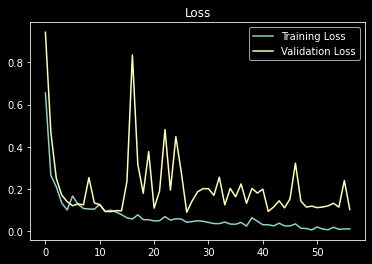

In [16]:
# Plot loss per epoch

train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

epochs = range(len(train_loss)) 

plt.plot(epochs, train_loss)
plt.plot(epochs, valid_loss)
plt.legend(["Training Loss", "Validation Loss"])
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

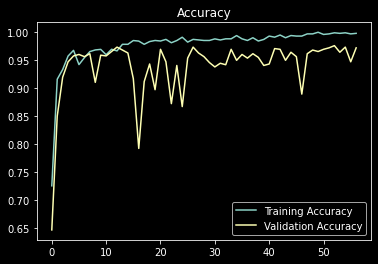

In [17]:
# Plot accuracy per epoch

train_acc = history.history["accuracy"]
valid_acc = history.history["val_accuracy"]

epochs = range(len(train_acc)) 

plt.plot(epochs, train_acc)
plt.plot(epochs, valid_acc)
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Accuracy")

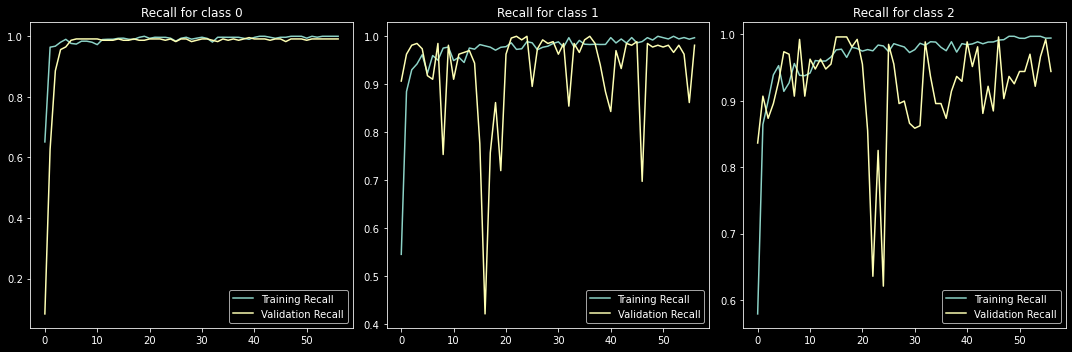

In [18]:
# Plot recall per epoch

fig, axs = plt.subplots(1, 3, figsize = (15, 5))

train_rec_0 = history.history["recall"]
valid_rec_0 = history.history["val_recall"]
train_rec_1 = history.history["recall_1"]
valid_rec_1 = history.history["val_recall_1"]
train_rec_2 = history.history["recall_2"]
valid_rec_2 = history.history["val_recall_2"]

epochs = range(len(train_rec_0)) 

axs[0].plot(epochs, train_rec_0)
axs[0].plot(epochs, valid_rec_0)
axs[0].legend(["Training Recall", "Validation Recall"])
axs[0].set_title("Recall for class 0")

axs[1].plot(epochs, train_rec_1)
axs[1].plot(epochs, valid_rec_1)
axs[1].legend(["Training Recall", "Validation Recall"])
axs[1].set_title("Recall for class 1")

axs[2].plot(epochs, train_rec_2)
axs[2].plot(epochs, valid_rec_2)
axs[2].legend(["Training Recall", "Validation Recall"])
axs[2].set_title("Recall for class 2")

fig.tight_layout()


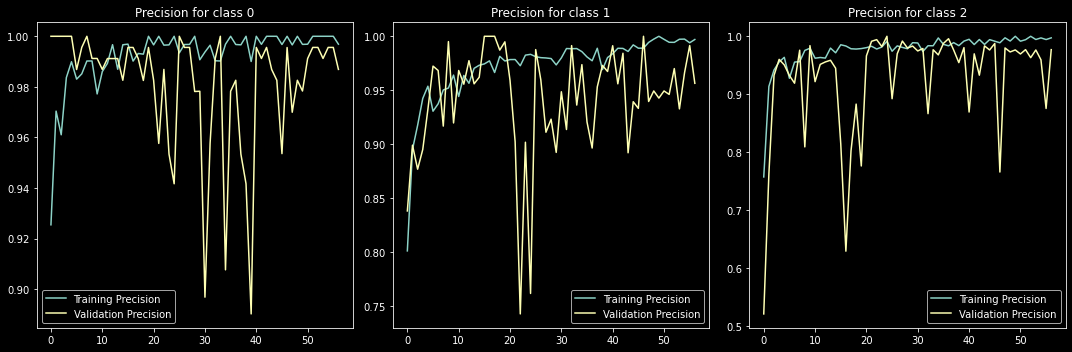

In [19]:
# Plot precision per epoch

fig, axs = plt.subplots(1, 3, figsize = (15, 5))

train_pre_0 = history.history["precision"]
valid_pre_0 = history.history["val_precision"]
train_pre_1 = history.history["precision_1"]
valid_pre_1 = history.history["val_precision_1"]
train_pre_2 = history.history["precision_2"]
valid_pre_2 = history.history["val_precision_2"]

epochs = range(len(train_pre_0)) 

axs[0].plot(epochs, train_pre_0)
axs[0].plot(epochs, valid_pre_0)
axs[0].legend(["Training Precision", "Validation Precision"])
axs[0].set_title("Precision for class 0")

axs[1].plot(epochs, train_pre_1)
axs[1].plot(epochs, valid_pre_1)
axs[1].legend(["Training Precision", "Validation Precision"])
axs[1].set_title("Precision for class 1")

axs[2].plot(epochs, train_pre_2)
axs[2].plot(epochs, valid_pre_2)
axs[2].legend(["Training Precision", "Validation Precision"])
axs[2].set_title("Precision for class 2")

fig.tight_layout()

In [20]:
# Sample random images from Validation Set for each class
valid_batch = next(valid_generator)
valid_class_0 = []
valid_class_1 = []
valid_class_2 = []
for i in range(100):
    rand = random.randint(0, BATCH_SIZE-1)
    image_onehot = valid_batch[1][rand]
#     print(image_onehot)
    if(image_onehot[0] == 1 and len(valid_class_0) < 5):
        valid_class_0.append(rand)
    elif(image_onehot[1] == 1 and len(valid_class_1) < 5):
        valid_class_1.append(rand)
    elif(image_onehot[2] == 1 and len(valid_class_2) < 5):
        valid_class_2.append(rand)
    
    if(len(valid_class_0) + len(valid_class_1) + len(valid_class_2) >= 15):
        break

### Activation Maps (Feature Maps)

In [21]:
print(len(cnn_model.layers))
for i in range(len(cnn_model.layers)):
    layer = cnn_model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

318
1 conv2d (None, 127, 127, 32)
4 conv2d_1 (None, 125, 125, 32)
7 conv2d_2 (None, 125, 125, 64)
11 conv2d_3 (None, 62, 62, 80)
14 conv2d_4 (None, 60, 60, 192)
18 conv2d_8 (None, 29, 29, 64)
21 conv2d_6 (None, 29, 29, 48)
22 conv2d_9 (None, 29, 29, 96)
28 conv2d_5 (None, 29, 29, 64)
29 conv2d_7 (None, 29, 29, 64)
30 conv2d_10 (None, 29, 29, 96)
31 conv2d_11 (None, 29, 29, 32)
41 conv2d_15 (None, 29, 29, 64)
44 conv2d_13 (None, 29, 29, 48)
45 conv2d_16 (None, 29, 29, 96)
51 conv2d_12 (None, 29, 29, 64)
52 conv2d_14 (None, 29, 29, 64)
53 conv2d_17 (None, 29, 29, 96)
54 conv2d_18 (None, 29, 29, 64)
64 conv2d_22 (None, 29, 29, 64)
67 conv2d_20 (None, 29, 29, 48)
68 conv2d_23 (None, 29, 29, 96)
74 conv2d_19 (None, 29, 29, 64)
75 conv2d_21 (None, 29, 29, 64)
76 conv2d_24 (None, 29, 29, 96)
77 conv2d_25 (None, 29, 29, 64)
87 conv2d_27 (None, 29, 29, 64)
90 conv2d_28 (None, 29, 29, 96)
93 conv2d_26 (None, 14, 14, 384)
94 conv2d_29 (None, 14, 14, 96)
101 conv2d_34 (None, 14, 14, 128)
104 conv2

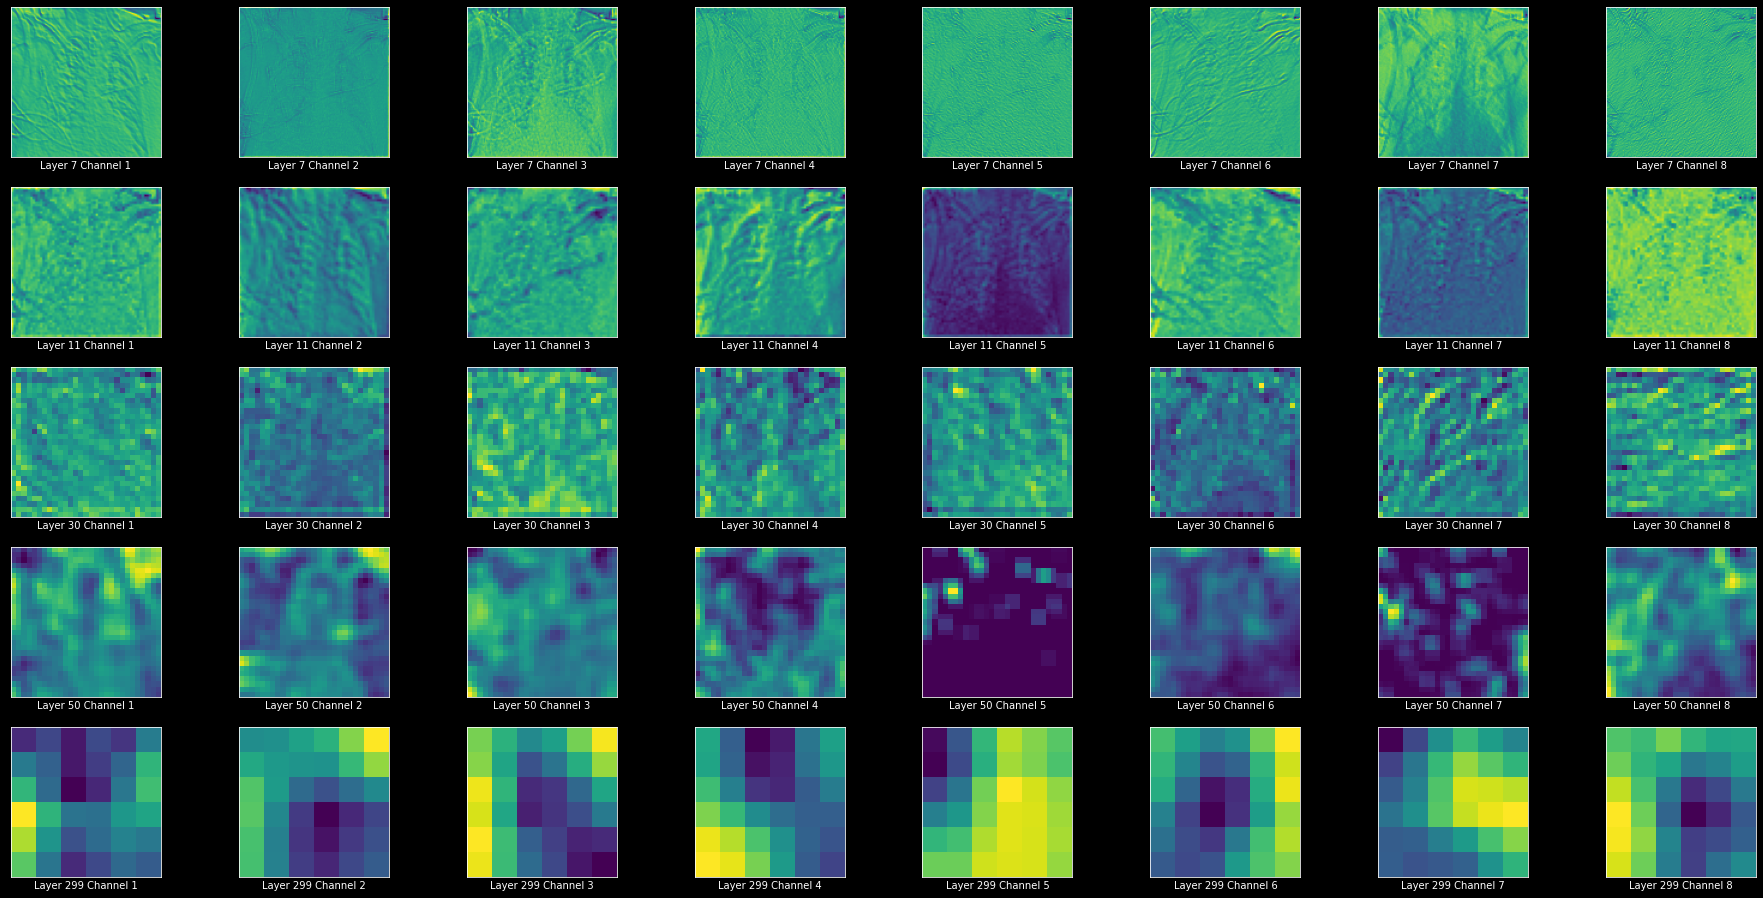

In [22]:
# Examinate Feature Map of Validation Set

# redefine model to output right after the first hidden layer
conv_list = [7, 11, 30, 50, 299] # 5 selected layers
outputs = [cnn_model.layers[i].output for i in conv_list]
model = Model(inputs=cnn_model.inputs, outputs=outputs)

# 8 channel for each selected layers
channels = 8
fig, axs = plt.subplots(len(conv_list), channels, figsize = (32, 16))

# Covid-19 Class Image
img = valid_batch[0][valid_class_0[3]]
# expand dimensions(to represent as a single 'sample')
img = np.expand_dims(img, axis=0)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
# 8 channels for 5 selected layers
for index, fmap in enumerate(feature_maps):
    for j in range(channels):
        # plot filter channel
        axs[index, j].imshow(fmap[0, :, :, j])
        info = "Layer " + str(conv_list[index]) + " Channel " + str(j+1) 
        axs[index, j].set(xlabel = info, xticks = [], yticks = [])
    
# show the figure
plt.show()  

### Compute Saliency Map 

In [29]:
# # (Optional) Load New Image
# valid_image = "/kaggle/input/covid19-radiography-database/COVID-19 Radiography Database/COVID-19/COVID-19 (10).png"
# _img = tf.keras.preprocessing.image.load_img(valid_image,target_size=(256,256))
# plt.imshow(_img)
# plt.show()

# # preprocess image to get it into the right format for the model
# img = tf.keras.preprocessing.image.img_to_array(_img)
# img = img.reshape((1, *img.shape))
# y_pred = cnn_model.predict(img)

valid_images = []
# Covid-19 Class Image
valid_images.append(valid_batch[0][valid_class_0[4]])
# Normal Class Image
valid_images.append(valid_batch[0][valid_class_1[4]])
# Viral Pneumonia Class Image
valid_images.append(valid_batch[0][valid_class_2[2]])

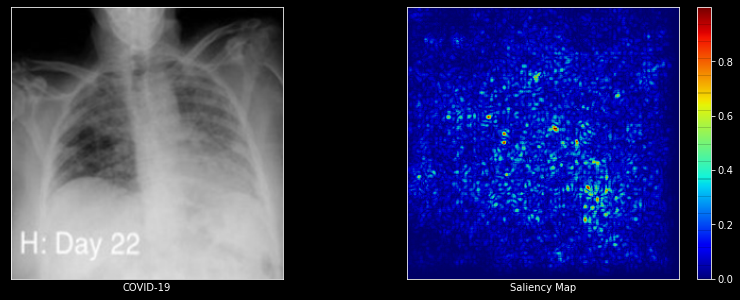

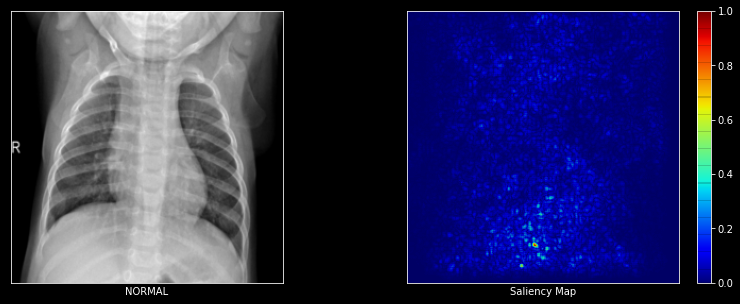

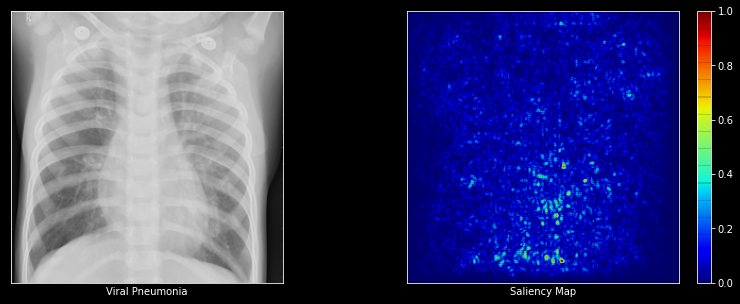

In [30]:
layers = [layer.output for layer in cnn_model.layers]

for i, _img in enumerate(valid_images):
    # expand dimensions(to represent as a single 'sample')
#     img = np.expand_dims(_img, axis=0)
    img = _img.reshape((1, *_img.shape))
    images = tf.Variable(img, dtype=float)

    with tf.GradientTape() as tape:
        tape.reset()
        pred = cnn_model(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]
        loss = pred[0][class_idxs_sorted[0]]
        

    grads = tape.gradient(loss, images)
    # print(grads.shape) #(1, 256, 256, 3)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]
    # print(dgrad_max_.shape) #(256, 256)

    ## normalize to range between 0 and 1
    arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)
    # print(grad_eval.shape) #(256, 256)
    
    fig, axs = plt.subplots(1, 2, figsize=(14,5))
    axs[0].imshow(_img)
    im = axs[1].imshow(grad_eval, cmap="jet", alpha=0.8)
    axs[0].set(xlabel = labels[i], xticks = [], yticks = [])
    axs[1].set(xlabel = "Saliency Map", xticks = [], yticks = [])
    fig.colorbar(im)
    
    plt.show()

Found 765 images belonging to 3 classes.


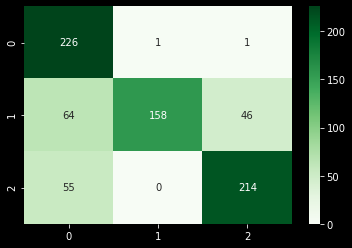

In [32]:
# Confusion Matrix 

# Use the validation set for testing
# Set shuffle=False to get stable model precdition and corresponding ground truth labels
valid_generator = datagen_val.flow_from_directory(
    directory = path,
    classes = labels,
    seed = SEED,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    subset = 'validation'
)

# Obtain predictions
pred = cnn_model.predict_generator(valid_generator) # Gives class probabilities
y_pred = np.round(pred) # Gives one-hot encoded classes
y_pred = np.argmax(y_pred, axis=1) # Gives class labels

# Obtain actual labels
y_true = valid_generator.classes
    
# Now plot matrix
cm = confusion_matrix(y_true, y_pred, labels = [0, 1, 2])
sns.heatmap(
    cm, 
    cmap="Greens",
    annot = True, 
    fmt = "d"
)
plt.show()

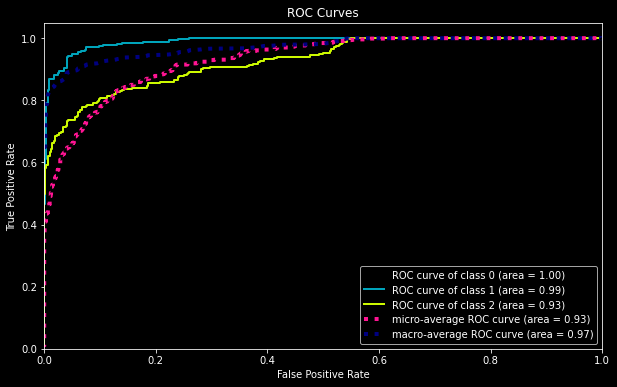

In [33]:
# ROC curve
fig, ax = plt.subplots(figsize=(10,6))
plot_roc(y_true, pred, ax=ax)

In [34]:
# precision, recall, f1-score, support
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.99      0.79       228
           1       0.99      0.59      0.74       268
           2       0.82      0.80      0.81       269

    accuracy                           0.78       765
   macro avg       0.82      0.79      0.78       765
weighted avg       0.83      0.78      0.78       765



In [35]:
# (Optional) Reload Model
covid19_detection_model = keras.models.load_model('/kaggle/working/detector.hdf5')